In [12]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
from collections import defaultdict
from typing import Optional, List, Tuple
import math
import sinter
import matplotlib
import rsmf 

formatter : plt.Formatter = rsmf.setup(r"\documentclass[a4paper,11pt,noarxiv]{quantumarticle}")
%matplotlib inline


In [13]:
def get_sinter_fit(log_ps, sqrt_qs, target_x):
    if len(log_ps) < 2:
        print('error, less than 2 points')
        return None
    
   # if len(log_ps) < 3:
    #    print("two points!")

    slope_fit = sinter.fit_line_slope(
        xs=log_ps,
        ys=sqrt_qs,
        max_extra_squared_error=1,
    )
    if slope_fit.low >= 0:
        return None
    
  #  if slope_fit.high >= 0:
        # Slope is going the wrong way! Definitely over threshold.
 #       print('error, slope is going the wrong way')
#        return None

    fit = sinter.fit_line_y_at_x(
        xs=log_ps,
        ys=sqrt_qs,
        target_x=target_x,
        max_extra_squared_error=1,
    )
    return (fit)

def extrapolate_footprint_achieving_error_rate(
        group: List[sinter.TaskStats],
        target_p: float,
        data: str,
) -> Optional[sinter.Fit]:
    """Taken from Craig Gidney's code.
    
    Args:
        group: A list of TaskStats objects.
        target_p: The target probability of failure, for teraquop use 1e-12.

    Returns:
        A Fit object representing the footprint that would achieve the target
        probability of failure, or None if the data was insufficient.
    """
    assert len({stat.json_metadata['per'] for stat in group}) == 1
    sqrt_qs = []
    log_ps = []
    for stat in group:
        if stat.shots:
            p_shot = stat.errors / stat.shots
            if 0 < p_shot < 0.5:

                p_unit = p_shot
                sqrt_qs.append(math.sqrt(stat.json_metadata[data]**2)) 
                log_ps.append(math.log(p_unit))
            

    return get_sinter_fit(log_ps, sqrt_qs, math.log(target_p))

In [14]:
def calc_teraquop_patch_diameter(stats,metric):
  
    code_name_groups = sinter.group_by(stats, key = lambda stat: (stat.json_metadata['code_name'], stat.json_metadata['gf_0'], stat.json_metadata['gf_1'], stat.json_metadata['gf_2']))


    footprints = defaultdict()
    for code_name_key, code_name_group in code_name_groups.items(): 
        footprints[code_name_key] = extrapolate_footprint_achieving_error_rate(
                code_name_group,
                10**(-12),
                metric)
        if footprints[code_name_key] == None:
            print('error, no footprints')
            print(code_name_key)
            print(code_name_group)
    return(footprints)

def float_to_color_shade(value: int, color_map: matplotlib.colors.LinearSegmentedColormap, vmin=200, vmax=3000):
    # Normalize the value to the range [0, 1]
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    normalized_value = norm(value)

    # Get the color corresponding to the normalized value
    color : Tuple[int,int,int,int]= color_map(normalized_value)
    return color


def format_code_label(code_name):
    code_name_to_label = {
        'GaugeHoneycombCode': 'HCC',
        'GaugeFloquetColourCode': 'FCC'
    }
    if code_name_to_label.get(code_name[0], code_name) == 'HCC':
        return(f"$X^{code_name[1:][0]}Y^{code_name[1:][1]}Z^{code_name[1:][2]}$")
    else:
        return(f"$X^{code_name[1:][0]}Z^{code_name[1:][1]}$") 
    
def plot_footprints(footprints, ax=plt, top_n=10, vmin=10,vmax=80, y_label='Volume'):

    sorted_items = sorted(footprints.items(), key=lambda item: item[1].best if item[1] is not None else float('inf'))
    code_name_to_color = {'GaugeFloquetColourCode': plt.cm.Reds, 'GaugeHoneycombCode': plt.cm.Greens}
    for code_name, footprint in sorted_items[:top_n]:
        formatted_label = format_code_label(code_name)      
        if 1.2*float(footprint.high) < vmax:      
            bars = ax.bar(str(code_name), float(footprint.best), color = float_to_color_shade(footprint.best, code_name_to_color.get(code_name[0], 'black'), vmin=vmin, vmax=vmax))
            ax.errorbar(str(code_name), float(footprint.best), yerr=[[float(footprint.best - footprint.low)], [float(footprint.high - footprint.best)],], fmt='o', color='black', ecolor='black', elinewidth=1, capsize=3)
            for bar in bars:
                height = 1.02 * footprint.high
                ax.text(bar.get_x() + bar.get_width() / 2.0, height, formatted_label, ha='center', va='bottom', rotation=90)
#    ax.set_ylim(0, 1.15* footprint.high)

    ax.set_xlabel('Codes')
    ax.set_xticks([]) 
    
    formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    formatter.fontsize = 11
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)


   
def calc_xz_hight(x_hights_stability, z_hights_stability):

    xz_hight = dict()
    for code_name, x_hight in x_hights_stability.items():

        if code_name in z_hights_stability:
            z_hight = z_hights_stability[code_name]
        else:
            z_hight = None

        if x_hight != None and z_hight != None:

            xz_hight[code_name] = sinter.Fit(low = (x_hight.low + z_hight.low)/2,
                                            best = (x_hight.best + z_hight.best)/2,
                                            high = (x_hight.high + z_hight.high)/2)
            

    return(xz_hight)

def low_error_for_multiplication(values, max_values):
    relative_error = 0
    abs_value = 1
    for value, max_value in zip(values, max_values):
        relative_error += (abs(max_value-value)/value)**2
        abs_value *= value
    
    relative_error = math.sqrt(relative_error)
    return(abs_value*(1-relative_error))

def high_error_for_multiplication(values, max_values):
    relative_error = 0
    abs_value = 1
    for value, max_value in zip(values, max_values):
        relative_error += (abs(max_value-value)/value)**2
        abs_value *= value

    relative_error = math.sqrt(relative_error)

    return(abs_value*(1+relative_error))


def calc_volumes(x_patch_diameters, z_patch_diameters, xz_hight):
    volumes = defaultdict()
    for code_name, x_patch_diameter in x_patch_diameters.items():
        if code_name in xz_hight and xz_hight[code_name] != None:
            if z_patch_diameters[code_name] != None and x_patch_diameter != None:
                low_fit = 3*low_error_for_multiplication([x_patch_diameter.best, z_patch_diameters[code_name].best, xz_hight[code_name].best], [x_patch_diameter.low, z_patch_diameters[code_name].low, xz_hight[code_name].low])
                high_fit = 3*high_error_for_multiplication([x_patch_diameter.best, z_patch_diameters[code_name].best, xz_hight[code_name].best], [x_patch_diameter.high, z_patch_diameters[code_name].high, xz_hight[code_name].high])

                volumes[code_name] = sinter.Fit(low=low_fit,
                        best= 3* x_patch_diameter.best * z_patch_diameters[code_name].best * xz_hight[code_name].best,
                        high=high_fit)

    return(volumes)
"""
def calc_number_of_qubits(x_patch_diameters, z_patch_diamters):
    number_of_qubits = defaultdict(dict)
    for code_name, diameter in x_patch_diameters.items():       
        if z_patch_diamters[code_name] != None and diameter != None:
            low_fit = low_error_for_multiplication([diameter.best, z_patch_diamters[code_name].best], [diameter.low, z_patch_diamters[code_name].low])
            high_fit = high_error_for_multiplication([diameter.best, z_patch_diamters[code_name].best], [diameter.high, z_patch_diamters[code_name].high])
            number_of_qubits[code_name] = sinter.Fit(low=3 * low_fit,
                                                    best=3 * diameter.best * z_patch_diamters[code_name].best,
                                                    high=3 * high_fit)
    return(number_of_qubits)
"""
#def calc_number_of_qubits(x_patch_diameters, z_patch_diamters):


def get_diameter_hights_volumes(stats, noise_model):
    stats_nm = [stat for stat in stats if stat.json_metadata['noise_model'] == noise_model]

    stats_nm_memory_x = [stat for stat in stats_nm if stat.json_metadata['logical_observable']== 'memory_x']
    stats_nm_memory_z = [stat for stat in stats_nm if stat.json_metadata['logical_observable']== 'memory_z']
    stats_nm_stability_x = [stat for stat in stats_nm if stat.json_metadata['logical_observable']== 'stability_x']
    stats_nm_stability_z = [stat for stat in stats_nm if stat.json_metadata['logical_observable']== 'stability_z']

    x_sides = calc_teraquop_patch_diameter(stats_nm_memory_x, 'distance')
    z_sides = calc_teraquop_patch_diameter(stats_nm_memory_z, 'distance')

    x_hight = calc_teraquop_patch_diameter(stats_nm_stability_x, 'n_rounds')
    z_hight = calc_teraquop_patch_diameter(stats_nm_stability_z, 'n_rounds')
    xz_hights = calc_xz_hight(x_hight, z_hight)
    
#    number_of_qubits = calc_number_of_qubits(x_sides, z_sides)
    volumes = calc_volumes(x_sides, z_sides, xz_hights)

    return(x_sides, z_sides, x_hight, z_hight, xz_hights, volumes)



In [15]:
def create_plot(noise_rate_1, noise_rate_2, noise_rate_3, decoder, vmins, vmaxs):
    stats_sdn : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/{noise_rate_1}.csv')
    stats_SI1000 : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/{noise_rate_2}.csv')
    stats_EM3 : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/{noise_rate_3}.csv')
    stats_sdn = [stat for stat in stats_sdn if stat.decoder == decoder]
    stats_SI1000 = [stat for stat in stats_SI1000 if stat.decoder == decoder]
    stats_EM3 = [stat for stat in stats_EM3 if stat.decoder == decoder]
    x_sides_SD6, z_sides_SD6, x_hights_SD6, z_hights_SD, xz_hights_SD6, volumes_SD6 = get_diameter_hights_volumes(stats_sdn, "standard_depolarizing_noise")

    x_sides_SI1000, z_sides_SI1000, x_hights_SI1000, z_hights_SI1000, xz_hights_SI1000, volumes_SI1000  = get_diameter_hights_volumes(stats_SI1000, 'SI1000')
    x_sides_EM3, z_sides_EM3, x_hights_EM3, z_hights_EM3,xz_hights_EM3, volumes_EM3 = get_diameter_hights_volumes(stats_EM3, 'EM3')
    print(volumes_EM3)
    from mpl_toolkits.axes_grid1.inset_locator import mark_inset

    fig = formatter.figure(wide=True, aspect_ratio=1.5)
    ax1, ax2, ax3 = fig.subplots(3,1)
    #fig.tight_layout()
    plot_footprints(volumes_SD6, ax=ax1, top_n=50, vmin = vmins[0],vmax = vmaxs[0])

    ax1.set_title(f'{decoder}, standard depolarizing noise, p={noise_rate_1}')
    ax1.set_ylabel(r'qubits $\times$ rounds')
    ax2.set_ylabel(r'qubits $\times$ rounds')
    plot_footprints(volumes_SI1000, ax=ax2, top_n=30, vmin=vmins[1],vmax=vmaxs[1])
 #   ax2ins = ax2.inset_axes([0.1, 0.4, 0.3, 0.5])
    #plot_footprints(volumes_SI1000, ax=ax2ins, top_n=7, vmin=1e7,vmax=3e8)
#    ax2ins.set_ylim(0, 14e7)

    plot_footprints(volumes_EM3, ax=ax3, top_n=30, vmin=vmins[2],vmax=vmaxs[2])

    ax1.set_ylim(0, vmaxs[0])
    ax2.set_title(f'{decoder}, superconducting inspired noise, p={noise_rate_2}')
    ax2.set_ylim(0, vmaxs[1])
  #  ax2ins.set_xlabel('')
    #mark_inset(ax2, ax2ins, loc1=3, loc2=4, fc="none", ec="0.8")
    ax3.set_title(f'{decoder}, EM3 noise, p={noise_rate_3}')
    ax3.set_ylabel(r'qubits $\times$ rounds')
    ax3.set_ylim(0, vmaxs[2])

    plt.savefig(f"plots/volumes_cln_{noise_rate_1}_{noise_rate_2}_{noise_rate_3}_{decoder}.pdf", bbox_inches='tight')


error, no footprints
('GaugeHoneycombCode', 1, 3, 1)
[sinter.TaskStats(strong_id='93efb5ecba9589b5498df389466585fb0032db6a209a4bd43fb598c5918bb2b1', decoder='pymatching', json_metadata={'code_name': 'GaugeHoneycombCode', 'distance': 12, 'gf_0': 1, 'gf_1': 3, 'gf_2': 1, 'logical_observable': 'stability_x', 'n_rounds': 61, 'noise_model': 'EM3', 'per': 0.005}, shots=2886, errors=110, seconds=1.1560000000000001), sinter.TaskStats(strong_id='9c9eebc7b64e3a6d761f7bc91dde6e9150083f9e42a5916a2ae6d36c82d0a12a', decoder='pymatching', json_metadata={'code_name': 'GaugeHoneycombCode', 'distance': 4, 'gf_0': 1, 'gf_1': 3, 'gf_2': 1, 'logical_observable': 'stability_x', 'n_rounds': 21, 'noise_model': 'EM3', 'per': 0.005}, shots=3343, errors=117, seconds=0.033), sinter.TaskStats(strong_id='45a4548081ea6bf26749be0088c3945b393d87a6c7fe5ae887d65cd68d61fab8', decoder='pymatching', json_metadata={'code_name': 'GaugeHoneycombCode', 'distance': 8, 'gf_0': 1, 'gf_1': 3, 'gf_2': 1, 'logical_observable': 'stab

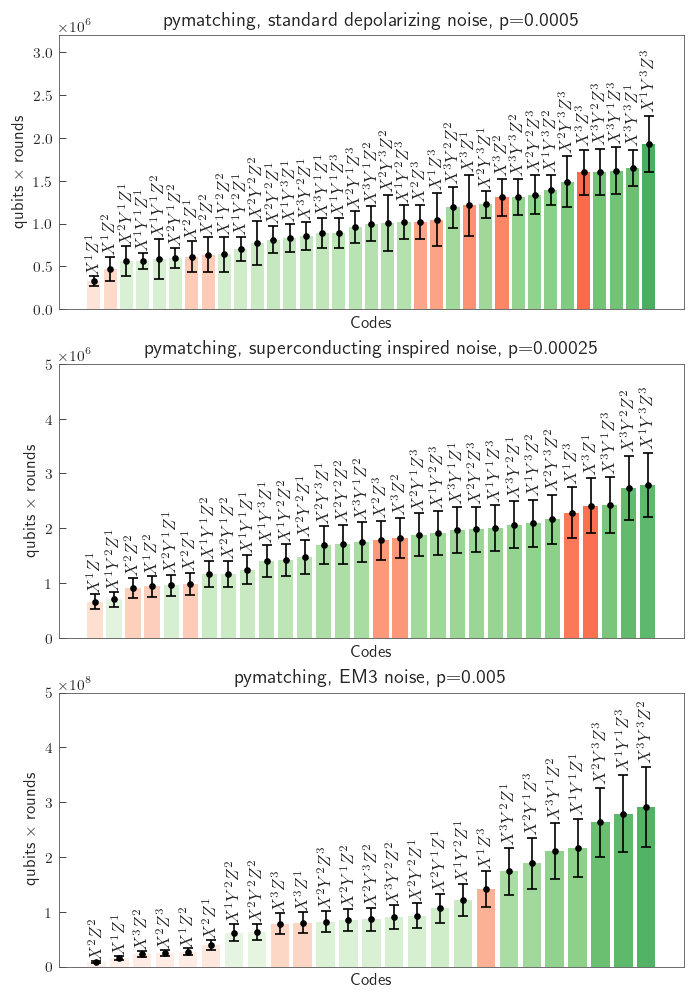

In [16]:
vmins = [10e2, 10e3, 10e3]
vmaxs = [3.2e6, 0.5e7, 5e8]
create_plot('0.0005', '0.00025', '0.005', 'pymatching', vmins, vmaxs)

defaultdict(None, {('GaugeFloquetColourCode', 1, 2, 0): sinter.Fit(low=3918331.639277626, best=7173024.414864676, high=10427717.190451726), ('GaugeFloquetColourCode', 1, 1, 0): sinter.Fit(low=1742221.277864378, best=3202704.8703823527, high=4663188.4629003275), ('GaugeFloquetColourCode', 1, 3, 0): sinter.Fit(low=4776608.552119897, best=8888355.012924606, high=13000101.473729316), ('GaugeFloquetColourCode', 2, 1, 0): sinter.Fit(low=2736169.5307997414, best=4980233.463599257, high=7224297.3963987725), ('GaugeFloquetColourCode', 2, 2, 0): sinter.Fit(low=1160820.0386289633, best=2094057.6582121176, high=3027295.277795272), ('GaugeFloquetColourCode', 2, 3, 0): sinter.Fit(low=4254478.290642241, best=7857281.710548599, high=11460085.130454957), ('GaugeFloquetColourCode', 3, 1, 0): sinter.Fit(low=4913952.023067754, best=8945134.836999388, high=12976317.650931023), ('GaugeFloquetColourCode', 3, 2, 0): sinter.Fit(low=2976421.845296179, best=5505091.771871574, high=8033761.69844697), ('GaugeFloqu

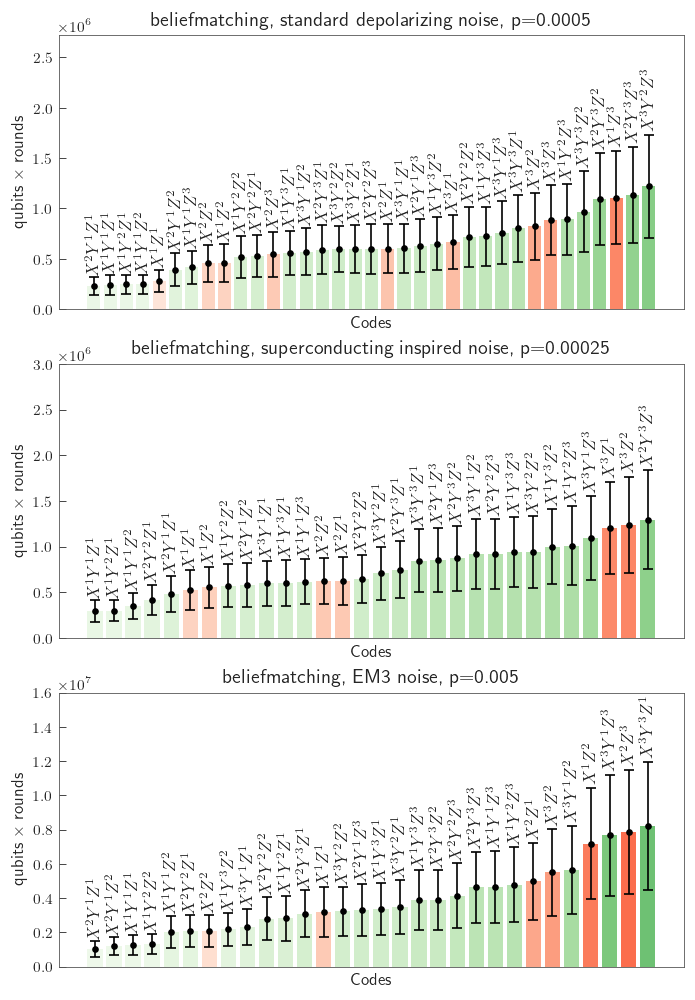

In [17]:
vmins = [10e2, 10e3, 10e3]
vmaxs = [2.72e6, 0.3e7, 1.6e7]
create_plot('0.0005', '0.00025','0.005', 'beliefmatching', vmins, vmaxs) 

In [7]:
def get_hcc_fcc_footprints(footprints, error_model, decoder):
#    footprints_all_codes = [diameter for key,diameter in footprints[decoder].items() if key == error_model]
    footprints_hcc_fcc = {key: diameter for key,diameter in footprints[0].items() if (key == ('GaugeFloquetColourCode', 1, 1, 0) or key == ('GaugeHoneycombCode', 1, 1, 1))}
    return footprints_hcc_fcc

def plot_all_footprints_fcc_hcc(footprints_list_pm, footprint_list_bm, error_model, ax=plt, x_labels=[], vmin=10,vmax=80, y_label = 'Patch diameter'):
    pos = 0
    code_name_to_color = {'GaugeFloquetColourCode': 'Red', 'GaugeHoneycombCode': 'Green'}

    for footprints_pm, footprints_bm in zip(footprints_list_pm, footprint_list_bm):

#        footprints_hcc_fcc_pymatching = get_hcc_fcc_footprints(footprints, error_model, 'pymatching')
 #       footprints_hcc_fcc_beliefmatching = get_hcc_fcc_footprints(footprints, error_model, 'beliefmatching')

        for code_name, footprint in footprints_pm.items():
#        for code_name, footprint in footprints_hcc_fcc_pymatching.items():
            ax : plt.axes
          
            bars = ax.bar(pos, float(footprint.best), color=code_name_to_color.get(code_name[0], 'black'), hatch='x', edgecolor='black')
            ax.errorbar(pos, float(footprint.best), yerr=[[float(footprint.best - footprint.low)], [float(footprint.high - footprint.best)],], fmt='o', color='black', ecolor='black', elinewidth=1, capsize=3)

            pos += 1
            bm_code_footprint = footprints_bm.get(code_name)
#            bm_code_footprint = footprints_hcc_fcc_beliefmatching.get(code_name)

            bars = ax.bar(pos, float(bm_code_footprint.best), color=code_name_to_color.get(code_name[0], 'black'), edgecolor='black')
            ax.errorbar(pos, float(bm_code_footprint.best), yerr=[[float(bm_code_footprint.best - bm_code_footprint.low)], [float(bm_code_footprint.high - bm_code_footprint.best)],], fmt='o', color='black', ecolor='black', elinewidth=1, capsize=3)
            pos += 1.2
        pos += 1

    formatter = matplotlib.ticker.ScalarFormatter(useMathText=True)
    formatter.fontsize = 11
    formatter.set_scientific(True)
    formatter.set_powerlimits((-1, 1))
    ax.yaxis.set_major_formatter(formatter)
    ax.set_ylabel(y_label)
    ax.set_xticks(x_labels) 

In [29]:
def filter_stats(stats, metadeta_entries: dict() = None, decoder = None):
    for metadeta_key, metadeta_value in metadeta_entries.items():
        stats = [stat for stat in stats if stat.json_metadata[metadeta_key] == metadeta_value]
    if decoder:
        stats = [stat for stat in stats if stat.decoder == decoder]
    print(stats)
    return stats


stats : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/0.0005.csv')
#stats_SI1000 : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/new_d_d_d_experiment_{noise_rate_2}.csv')
#stats_EM3 : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/d_d_d_experiment_{noise_rate_3}.csv')
#stats_EM3 += sinter.stats_from_csv_files(f'./out/nd_d_d_experiment_{noise_rate_3}.csv')

stats_sdn_pm = filter_stats(stats, {'noise_model': 'standard_depolarizing_noise', 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 0}, 'pymatching')
stats_sdn_pm += filter_stats(stats, {'noise_model': 'standard_depolarizing_noise', 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 1}, 'pymatching')

stats_sdn_bm = filter_stats(stats, {'noise_model': 'standard_depolarizing_noise', 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 0}, 'beliefmatching')
stats_sdn_bm += filter_stats(stats, {'noise_model': 'standard_depolarizing_noise', 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 1}, 'beliefmatching')

#stats_SI1000 = [stat for stat in stats_SI1000 if stat.decoder == decoder]
#stats_EM3 = [stat for stat in stats_EM3 if stat.decoder == decoder]

x_sides_SD6, z_sides_SD6, x_hights_SD6, z_hights_SD6, xz_hights_SD6, volumes_SD6 = get_diameter_hights_volumes(stats_sdn_pm, "standard_depolarizing_noise")
x_sides_SD6_bm, z_sides_SD6_bm, x_hights_SD6_bm, z_hights_SD6_bm, xz_hights_SD6_bm, volumes_SD6_bm = get_diameter_hights_volumes(stats_sdn_bm, "standard_depolarizing_noise")
#x_sides_SI1000, z_sides_SI1000, xz_hights_SI1000, volumes_SI1000  = get_diameter_hights_volumes(stats_SI1000, 'SI1000')
#x_sides_EM3, z_sides_EM3, xz_hights_EM3, volumes_EM3 = get_diameter_hights_volumes(stats_EM3, 'EM3')

[sinter.TaskStats(strong_id='5bf667de60f386fb5c982585b329da37ed5e4cdb98ea84a13cb8d253367d2d36', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 1, 'gf_2': 0, 'logical_observable': 'memory_z', 'n_rounds': 48, 'noise_model': 'standard_depolarizing_noise', 'per': 0.0005}, shots=600000, errors=3, seconds=39.12), sinter.TaskStats(strong_id='ac35b15f0b6ddcb715d8328ee804cb770acfba745fd77c0160a6544aef23b3b5', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 1, 'gf_2': 0, 'logical_observable': 'stability_z', 'n_rounds': 48, 'noise_model': 'standard_depolarizing_noise', 'per': 0.0005}, shots=300000, errors=1, seconds=18.448), sinter.TaskStats(strong_id='e1d896c09efd78219f22419be79ef5d5b857aa6066717ea5b227bb96359ce7de', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 1, 'gf_2': 0, 'logical_observable': 'stabilit

False
[sinter.TaskStats(strong_id='5bf667de60f386fb5c982585b329da37ed5e4cdb98ea84a13cb8d253367d2d36', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 1, 'gf_2': 0, 'logical_observable': 'memory_z', 'n_rounds': 48, 'noise_model': 'standard_depolarizing_noise', 'per': 0.0005}, shots=600000, errors=3, seconds=39.12), sinter.TaskStats(strong_id='ac35b15f0b6ddcb715d8328ee804cb770acfba745fd77c0160a6544aef23b3b5', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 1, 'gf_2': 0, 'logical_observable': 'stability_z', 'n_rounds': 48, 'noise_model': 'standard_depolarizing_noise', 'per': 0.0005}, shots=300000, errors=1, seconds=18.448), sinter.TaskStats(strong_id='e1d896c09efd78219f22419be79ef5d5b857aa6066717ea5b227bb96359ce7de', decoder='pymatching', json_metadata={'code_name': 'GaugeFloquetColourCode', 'distance': 12, 'gf_0': 1, 'gf_1': 1, 'gf_2': 0, 'logical_observable': 'st

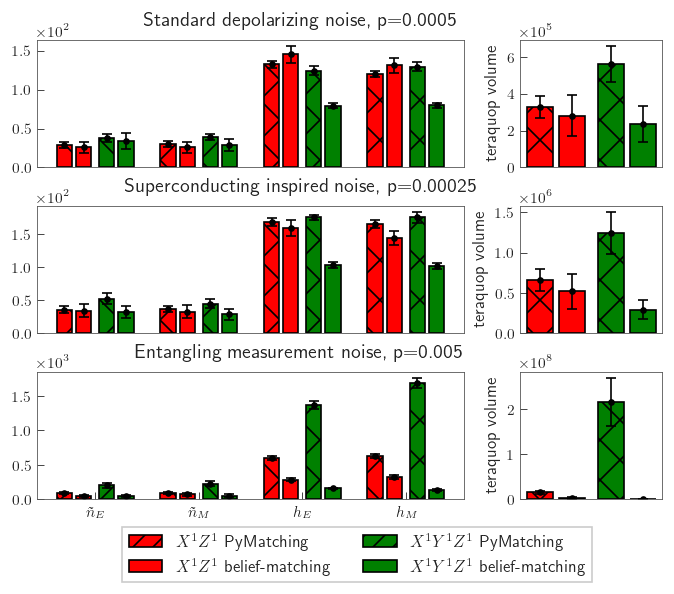

In [48]:

import matplotlib.patches as mpatches

fig = formatter.figure(wide=True)
subfigs = fig.subfigures(nrows=3, ncols=1)

x_labels = ['$\\tilde{n}_E$', '$\\tilde{n}_M$', '$h_E$', '$h_M$']
def gen_plot(axs, noise_rate, noise_model):
    stats : List[sinter.TaskStats] = sinter.stats_from_csv_files(f'./out/data/{noise_rate}.csv')
    print(stats[0].json_metadata['noise_model'] == noise_model)
    stats_sdn_pm = filter_stats(stats, {'noise_model': noise_model, 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 0}, 'pymatching')
    stats_sdn_pm += filter_stats(stats, {'noise_model': noise_model, 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 1}, 'pymatching')
#    print(stats_sdn_pm[0].json_metadata)
    stats_sdn_bm = filter_stats(stats, {'noise_model': noise_model, 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 0}, 'beliefmatching')
    stats_sdn_bm += filter_stats(stats, {'noise_model': noise_model, 'gf_0' : 1, 'gf_1' : 1, 'gf_2' : 1}, 'beliefmatching')

    x_sides_SD6, z_sides_SD6, x_hights_SD6, z_hights_SD6, _,volume_pm = get_diameter_hights_volumes(stats_sdn_pm, noise_model)
    x_sides_SD6_bm, z_sides_SD6_bm, x_hights_SD6_bm, z_hights_SD6_bm, _,volume_bm= get_diameter_hights_volumes(stats_sdn_bm, noise_model)
    plot_all_footprints_fcc_hcc([x_sides_SD6, z_sides_SD6, x_hights_SD6, z_hights_SD6], [x_sides_SD6_bm, z_sides_SD6_bm, x_hights_SD6_bm, z_hights_SD6_bm],'1.0,1.0,1.0,1.0', axs[0], y_label= '')
    plot_all_footprints_fcc_hcc([volume_pm],[volume_bm], '1.0,1.0,1.0,1.0', axs[1], y_label= 'teraquop volume')

#subfigs[0].suptitle(f'Standard depolarizing noise, p=0.0005')
#    ax1.set_title(f'{decoder}, standard depolarizing noise, p={noise_rate_1}')

row_0 = subfigs[0].subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1]})
gen_plot(row_0, '0.0005', 'standard_depolarizing_noise')

row_1 = subfigs[1].subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1]})
gen_plot(row_1, '0.00025', 'SI1000')
#subfigs[1].suptitle(f'Superconducting inspired noise, p=0.00025')

row_2 = subfigs[2].subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [3, 1]})
gen_plot(row_2,  '0.005', 'EM3')
subfigs[0].suptitle(f'Standard depolarizing noise, p=0.0005', y=1.05, x=0.45)
subfigs[1].suptitle(f'Superconducting inspired noise, p=0.00025', y=1.05, x=0.45)
subfigs[2].suptitle(f'Entangling measurement noise, p=0.005', y=1.05, x=0.45)



x_labels = ['$\\tilde{n}_E$', '$\\tilde{n}_M$', '$h_E$', '$h_M$']
row_2[0].set_xticks([1.6,7,12.375,17.8], x_labels)

red_patch_pm = mpatches.Patch(label='$X^1Z^1$ PyMatching', edgecolor='black', hatch='//', facecolor='red')
red_patch_bm = mpatches.Patch(label='$X^1Z^1$ belief-matching', edgecolor='black', facecolor='red')
green_patch_pm = mpatches.Patch(facecolor='green', label='$X^1Y^1Z^1$ PyMatching', edgecolor='black', hatch='//')
green_patch_bm = mpatches.Patch(facecolor='green', label='$X^1Y^1Z^1$ belief-matching', edgecolor='black')

row_2[0].legend(handles=[red_patch_pm, red_patch_bm, green_patch_pm, green_patch_bm], loc='upper center', bbox_to_anchor=(0.75, -0.15), ncol=2)

plt.savefig(f"plots/X1Y1Z1_X1Z1_comparison_cln.pdf", bbox_inches='tight')


In [9]:
stats_000025 : List[sinter.TaskStats] = sinter.stats_from_csv_files('./out/data/0.00025.csv')

stats_00025_pymatching = [stat for stat in stats_000025 if stat.decoder == 'pymatching']
x_sides_SD6, z_sides_SD6, xz_hights_SD6, volumes_SD6 = get_diameter_hights_volumes(stats_000025, "standard_depolarizing_noise")
x_sides_SI1000, z_sides_SI1000, xz_hights_SI1000, volumes_SI1000  = get_diameter_hights_volumes(stats_000025, 'SI1000')


ValueError: too many values to unpack (expected 4)

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig = formatter.figure(wide=True, aspect_ratio=1.2)
ax1 : plt.Axes
ax2 : plt.Axes
ax1, ax2 = fig.subplots(2,1)
#fig.tight_layout()
plot_footprints(volumes_SD6, ax=ax1, top_n=50, vmin=10e3,vmax=1.5e6)

ax1.set_title('Standard depolarizing noise')
ax1.set_ylabel(r'qubits $\times$ rounds')
ax2.set_ylabel(r'qubits $\times$ rounds')
plot_footprints(volumes_SI1000, ax=ax2, top_n=30, vmin=1e7,vmax=3e8)
ax2ins = ax2.inset_axes([0.1, 0.4, 0.3, 0.5])
#plot_footprints(volumes_SI1000, ax=ax2ins, top_n=7, vmin=1e7,vmax=3e8)
ax2ins.set_ylim(0, 14e7)
ax1.set_ylim(0, 22e5)
ax2.set_title('Superconducting inspired noise')
ax2.set_ylim(0, 15e6)
ax2ins.set_xlabel('')
mark_inset(ax2, ax2ins, loc1=3, loc2=4, fc="none", ec="0.8")

plt.savefig("volumes_cln_0.00025.png", bbox_inches='tight')


In [9]:
stats_00005 : List[sinter.TaskStats] = sinter.stats_from_csv_files('./out/new_d_d_d_experiment_0.0005.csv')
print(stats_00005[0].decoder)
stats_0005_pymatching = [stat for stat in stats_00005 if stat.decoder == 'pymatching']
x_sides_SD6, z_sides_SD6, xz_hights_SD6, volumes_SD6 = get_diameter_hights_volumes(stats_00005, "standard_depolarizing_noise")
x_sides_SI1000, z_sides_SI1000, xz_hights_SI1000, volumes_SI1000  = get_diameter_hights_volumes(stats_00005, 'SI1000')


pymatching
dict_keys([('GaugeFloquetColourCode', 1, 1, 0), ('GaugeFloquetColourCode', 1, 2, 0), ('GaugeFloquetColourCode', 1, 3, 0), ('GaugeFloquetColourCode', 2, 1, 0), ('GaugeFloquetColourCode', 2, 2, 0), ('GaugeFloquetColourCode', 2, 3, 0), ('GaugeFloquetColourCode', 3, 1, 0), ('GaugeFloquetColourCode', 3, 2, 0), ('GaugeFloquetColourCode', 3, 3, 0), ('GaugeHoneycombCode', 1, 1, 2), ('GaugeHoneycombCode', 1, 1, 1), ('GaugeHoneycombCode', 1, 1, 3), ('GaugeHoneycombCode', 1, 2, 1), ('GaugeHoneycombCode', 1, 2, 2), ('GaugeHoneycombCode', 1, 2, 3), ('GaugeHoneycombCode', 1, 3, 1), ('GaugeHoneycombCode', 1, 3, 2), ('GaugeHoneycombCode', 1, 3, 3), ('GaugeHoneycombCode', 2, 1, 1), ('GaugeHoneycombCode', 2, 1, 2), ('GaugeHoneycombCode', 2, 1, 3), ('GaugeHoneycombCode', 2, 2, 1), ('GaugeHoneycombCode', 2, 2, 2), ('GaugeHoneycombCode', 2, 2, 3), ('GaugeHoneycombCode', 2, 3, 1), ('GaugeHoneycombCode', 2, 3, 2), ('GaugeHoneycombCode', 2, 3, 3), ('GaugeHoneycombCode', 3, 1, 1), ('GaugeHoneycombCo

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig = formatter.figure(wide=True, aspect_ratio=1.2)
ax1 : plt.Axes
ax2 : plt.Axes
ax1, ax2 = fig.subplots(2,1)
#fig.tight_layout()
plot_footprints(volumes_SD6, ax=ax1, top_n=50, vmin=10e3,vmax=1.5e6)

ax1.set_title('Standard depolarizing noise')
ax1.set_ylabel(r'qubits $\times$ rounds')
ax2.set_ylabel(r'qubits $\times$ rounds')
plot_footprints(volumes_SI1000, ax=ax2, top_n=30, vmin=1e7,vmax=3e8)
ax2ins = ax2.inset_axes([0.1, 0.4, 0.3, 0.5])
#plot_footprints(volumes_SI1000, ax=ax2ins, top_n=7, vmin=1e7,vmax=3e8)
ax2ins.set_ylim(0, 14e7)
#ax1.set_ylim(0, 22e5)
ax2.set_title('Superconducting inspired noise')
ax2.set_ylim(0, 15e8)
ax2ins.set_xlabel('')
mark_inset(ax2, ax2ins, loc1=3, loc2=4, fc="none", ec="0.8")

plt.savefig("volumes_cln_0.0005.png", bbox_inches='tight')


In [11]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig = formatter.figure(wide=True)
ax1 : plt.Axes
ax2 : plt.Axes
ax1 = fig.subplots(1,1)
#fig.tight_layout()
plot_footprints(volumes_SD6, ax=ax1, top_n=30, vmin=10e4,vmax=1.5e6)

ax1.set_title('Standard depolarizing noise')
ax1.set_ylabel(r'qubits $\times$ rounds')
#ax2.set_ylabel(r'qubits $\times$ rounds')
#plot_footprints(volumes_SI1000, ax=ax2, top_n=30, vmin=1e7,vmax=3e8)
#ax2ins = ax2.inset_axes([0.1, 0.4, 0.3, 0.5])
#plot_footprints(volumes_SI1000, ax=ax2ins, top_n=7, vmin=1e7,vmax=3e8)
#ax2ins.set_ylim(0, 14e7)
ax1.set_ylim(0, 22e5)
#ax2.set_title('Superconducting inspired noise')
#ax2.set_ylim(0, 15e8)
#ax2ins.set_xlabel('')
#mark_inset(ax2, ax2ins, loc1=3, loc2=4, fc="none", ec="0.8")

plt.savefig("volumes_cln_hor.png", bbox_inches='tight')


In [12]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig = formatter.figure(wide=True)
ax1 : plt.Axes
ax2 : plt.Axes
ax2 = fig.subplots(1,1)
#fig.tight_layout()
plot_footprints(volumes_SD6, ax=ax1, top_n=30, vmin=10e4,vmax=1.5e6)

#ax1.set_title('Standard depolarizing noise')
#ax1.set_ylabel(r'qubits $\times$ rounds')
ax2.set_ylabel(r'qubits $\times$ rounds')
plot_footprints(volumes_SI1000, ax=ax2, top_n=30, vmin=1e7,vmax=3e8)
ax2ins = ax2.inset_axes([0.1, 0.4, 0.3, 0.5])
plot_footprints(volumes_SI1000, ax=ax2ins, top_n=7, vmin=1e7,vmax=3e8)
ax2ins.set_ylim(0, 14e7)
#ax1.set_ylim(0, 22e5)
ax2.set_title('Superconducting inspired noise')
ax2.set_ylim(0, 15e8)
ax2ins.set_xlabel('')
mark_inset(ax2, ax2ins, loc1=3, loc2=4, fc="none", ec="0.8")

plt.savefig("volumes_cln_hor_2.png", bbox_inches='tight')

In [13]:
print(volumes_SI1000[("GaugeFloquetColourCode",1,1,0)].best*10e-7)
print(volumes_SI1000[("GaugeHoneycombCode",2 ,1,1)].best*10e-8)
print(volumes_SI1000[("GaugeFloquetColourCode",1,1,0)].best/volumes_SI1000[("GaugeHoneycombCode",2,1,1)].best)


16.376942287361558


KeyError: ('GaugeHoneycombCode', 2, 1, 1)

In [ ]:
print(volumes_SD6[("GaugeFloquetColourCode",1,1,0)].best*10e-7)
print(volumes_SD6[("GaugeHoneycombCode",1,1,2)].best*10e-8)
print(volumes_SD6[("GaugeFloquetColourCode",1,1,0)].best/volumes_SD6[("GaugeHoneycombCode",2,1,1)].best)

0.3864375980209349
0.04889525219116492
0.7111115530252596
